# QCoCircuits

## Circuit construction
A new circuit can be constructed as a `DeclarativeCircuit` instance and implements the `IDeclarativeCircuit` interface.
Operations can be added to circuits through the `add` method.
Each operation implements the `ICircuitOperation` interface containing a relation component (`IRelationComponent`) and channel identifier (`ChannelIdentifier`).

(<Figure size 200x120 with 1 Axes>, <Axes: >)

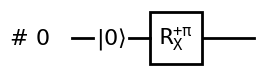

In [1]:
from qce_circuit import (
    IDeclarativeCircuit,
    DeclarativeCircuit,
    Rx180,
    plot_circuit,
)

circuit: IDeclarativeCircuit = DeclarativeCircuit()
qubit_index_0: int = 0
circuit.add(Rx180(qubit_index_0))

plot_circuit(circuit)

Operations can be specified with specific relations (`RelationType`) to other operations. Operations cover one or more channel identifiers. Each identifier contains one qubit identifier (`int`) and one `QubitChannel` enum (`READOUT`, `MICROWAVE`, `FLUX`, `ALL`). Operation relations and timings are processed independently between qubit channels unless otherwise specified.

(<Figure size 300x240 with 1 Axes>, <Axes: >)

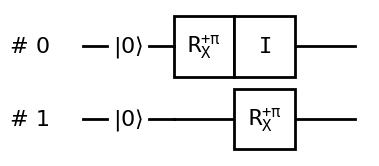

In [2]:
from qce_circuit import (
    ICircuitOperation,
    Identity,
    RelationLink,
    RelationType,
)

reference_operation: ICircuitOperation = Identity(qubit_index_0)
circuit.add(reference_operation)

qubit_index_1: int = 1
relation = RelationLink(reference_operation, RelationType.JOINED_END)
circuit.add(Rx180(qubit_index_1, relation=relation))

plot_circuit(circuit)

## Registers
Registers are used to keep track of interdependent operation properties.
They are passed during operation construction and a promise (strategy) on how to implement a property of the operation.
Types of registers are: `duration`, `repetition`, `conditional` or `acquisition` registers.
The first three define a property of the operation which can be updated by using the corresponding registry.
The `acquisition` registry is used to relate a unique acquisition index with a circuit operation.

(<Figure size 600x120 with 1 Axes>, <Axes: >)

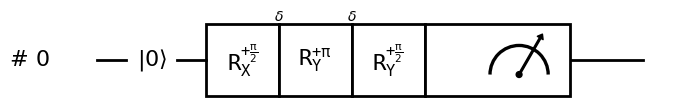

In [3]:
from qce_circuit import (
    RegistryRepetitionStrategy,
    RegistryDurationStrategy,
    RegistryAcquisitionStrategy,
    RepetitionRegistry,
    DurationRegistry,
    AcquisitionRegistry,
    Wait,
    DispersiveMeasure,
    Ry180,
    Ry90,
    Rx90,
)

duration_registry = DurationRegistry()
duration_strategy = RegistryDurationStrategy(duration_registry, registry_key='tau')

repetition_registry = RepetitionRegistry()
repetition_strategy = RegistryRepetitionStrategy(repetition_registry, registry_key='inner_repetitions')

outer_circuit: IDeclarativeCircuit = DeclarativeCircuit()  # Defaults to (fixed) single repetition strategy
inner_circuit: IDeclarativeCircuit = DeclarativeCircuit(repetition_strategy=repetition_strategy)

inner_circuit.add(Rx90(0))
inner_circuit.add(Wait(0, duration_strategy=duration_strategy))
inner_circuit.add(Ry180(0))
inner_circuit.add(Wait(0, duration_strategy=duration_strategy))  # Registries can be shared among operations
inner_circuit.add(Ry90(0))

outer_circuit.add(inner_circuit)  # Circuits are effectively composite operations
outer_circuit.add(DispersiveMeasure(
    qubit_index=0, 
    acquisition_strategy=outer_circuit.get_acquisition_strategy(),
    acquisition_tag='final_measurement',
))

plot_circuit(outer_circuit)

Note that the circuit contains two wait operations with the same duration strategy, an inner-circuit block with (default 1) repetition strategy and a measurement operation connected to the outer-circuit acquisition strategy.
Registries allow us to enforce post-construction updates to the circuit. This is ideal for defining experiments where often variations of the same circuit are executed.

(<Figure size 800x120 with 1 Axes>, <Axes: >)

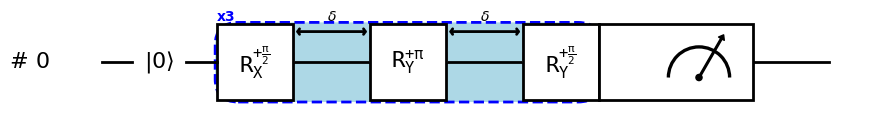

In [4]:
duration_registry.set_registry_at(key='tau', value=1.0)
repetition_registry.set_registry_at(key='inner_repetitions', value=3)

plot_circuit(outer_circuit)

# Circuit conversion

## Stim library

## OpenQL library

## Quantify library (coming soon)

# Streamlined construction using circuit descriptions

## Repetition-code circuit & layout

(<Figure size 2000x500 with 4 Axes>, <Axes: >)

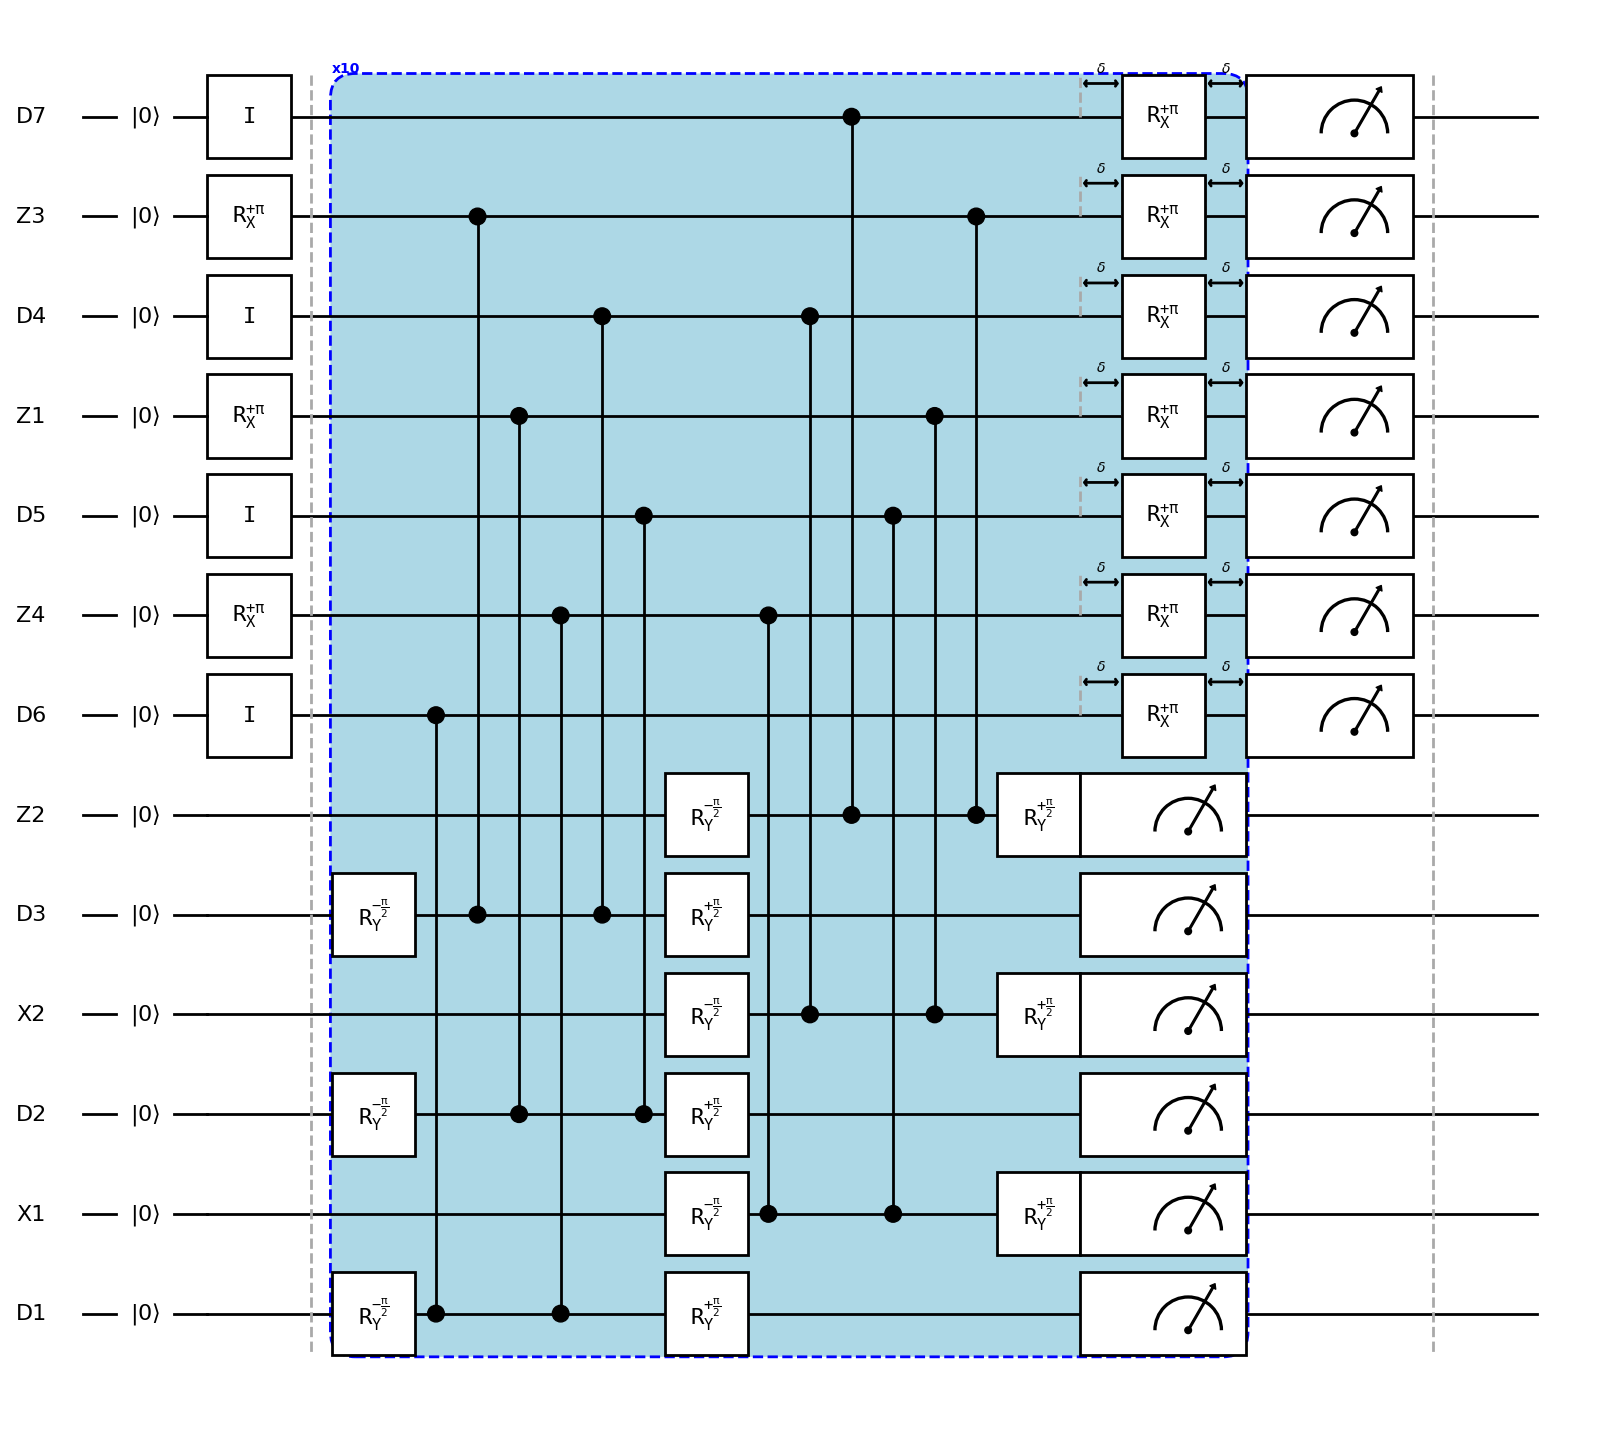

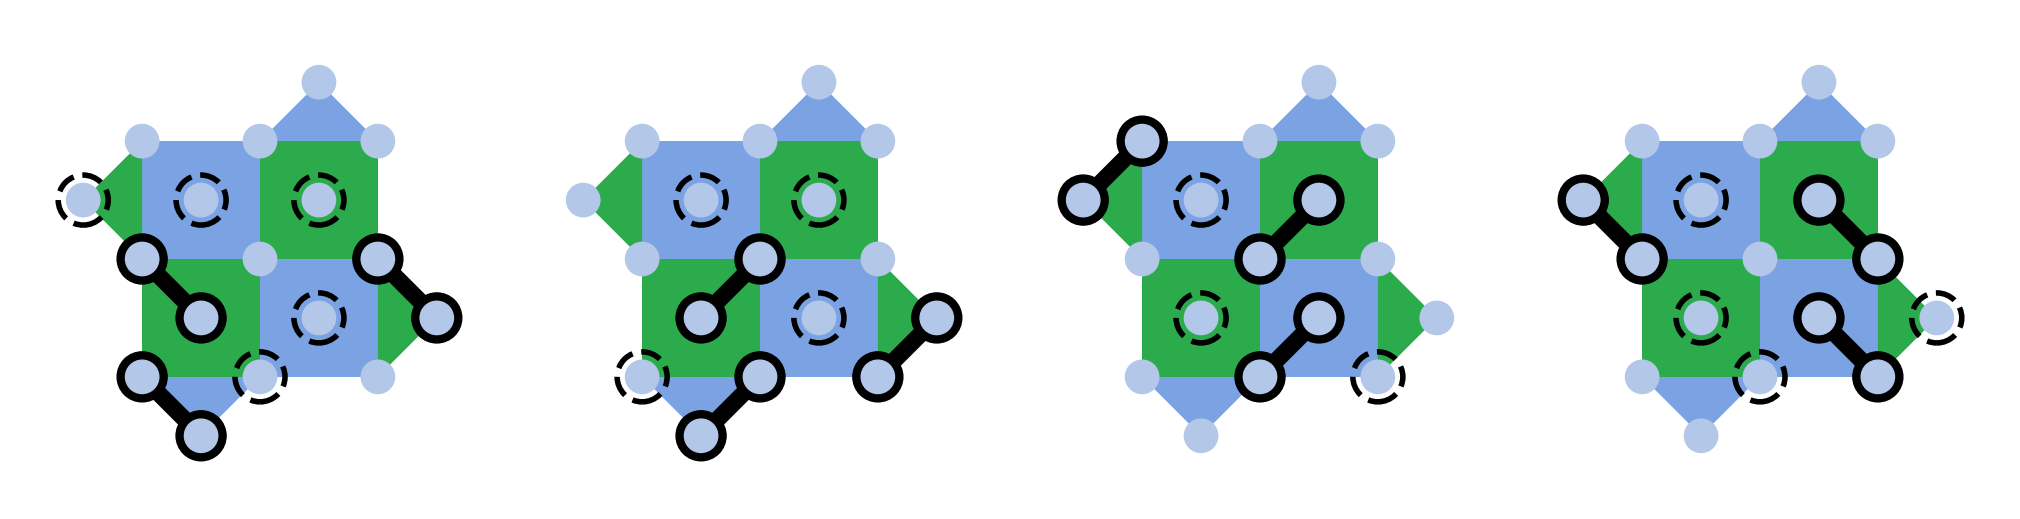

In [5]:
from qce_circuit import (
    plot_circuit,
    plot_gate_sequences,
)
from qce_circuit.language import (
    InitialStateContainer,
    InitialStateEnum,
)
from qce_circuit.connectivity.intrf_channel_identifier import (
    QubitIDObj,
)
from qce_circuit.library.repetition_code import (
    IRepetitionCodeDescription,
    RepetitionCodeDescription,
    construct_repetition_code_circuit_simplified,
    Repetition9Code,
)

circuit_description: IRepetitionCodeDescription = RepetitionCodeDescription.from_connectivity(
    involved_qubit_ids=[
        QubitIDObj('D7'),
        QubitIDObj('Z3'),
        QubitIDObj('D4'),
        QubitIDObj('Z1'),
        QubitIDObj('D5'),
        QubitIDObj('Z4'),
        QubitIDObj('D6'),
        QubitIDObj('Z2'),
        QubitIDObj('D3'),
        QubitIDObj('X2'),
        QubitIDObj('D2'),
        QubitIDObj('X1'),
        QubitIDObj('D1'),
    ],
    connectivity=Repetition9Code(),
)

circuit = construct_repetition_code_circuit_simplified(
    qec_cycles=10,
    description=circuit_description,
    initial_state=InitialStateContainer.from_ordered_list([
        InitialStateEnum.ZERO,
        InitialStateEnum.ONE,
        InitialStateEnum.ZERO,
        InitialStateEnum.ONE,
        InitialStateEnum.ZERO,
        InitialStateEnum.ONE,
        InitialStateEnum.ZERO,
    ]),
)

channel_map = {key: value.id for key, value in circuit_description.circuit_channel_map.items()}
plot_circuit(circuit, channel_map=channel_map)
plot_gate_sequences(circuit_description.to_sequence())

## Quick Setup Guide

### Cloning the repository

1. Open your terminal or command prompt.
2. Clone the repository using:
```bash
git clone git@github.com:MiniSean/QCoCircuits.git
```
3. Navigate to the repository root:
```bash
cd QCoCircuits
```

### Setting up the virtual environment
1. Create a virtual environment in the repository root:
```bash
python -m venv .venv
```
2. Activate the virtual environment:
- On Windows:
```bash
.venv\Scripts\activate
```
- On Unix or MacOS:
```bash
source .venv/bin/activate
```

### Installing Dependencies
1. Install the required packages:
```bash
pip install -r requirements.txt
```

### Running Jupyter Notebooks
1. If not already installed, install Jupyter Notebook:
```bash
pip install notebook
```
2. Launch Jupyter Notebook:
```bash
jupyter notebook
```
3. Your default web browser should open with the Jupyter interface. Navigate to  `QCoCircuits\src\qce_circuit\examples.ipynb` file and open it.
4. Run the notebook cells as needed.